# Mini MVP

In [1]:
import time

import nglview
from openff.toolkit import ForceField, Molecule, Topology
from openff.units import unit

from openff.interchange import Interchange
from openff.interchange.components._packmol import UNIT_CUBE, pack_box
from openff.interchange.drivers import get_summary_data

import openmm
import openmm.app
import openmm.unit

import numpy

import mdtraj

from openpharmmdflow import from_cif

1 molecule converted


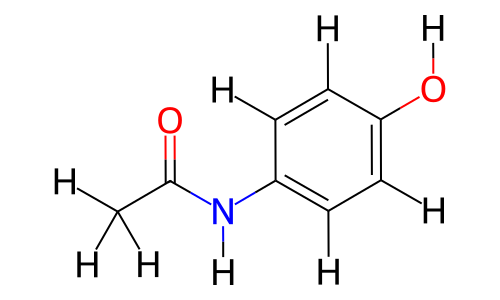

In [4]:
molecules = from_cif("../../inputs/small_molecule/HXACAN.cif")
# make bespoke ff from molecule(s)
molecules.visualize()

In [5]:
topology = pack_box(
    molecules=[molecules],
    number_of_copies=[200],
    mass_density=850 * unit.kilogram / unit.meter**3,
    box_shape=UNIT_CUBE,
)
# small mol
# slab (xstal with given face exposed z, xy pbc, what to "fill" z plane at given density, no fractional mols (if com is inside slab, generate)
# specify mol, unit cel parms,
# for csp, you don't want the xstal to force the mol into a confirmation
# pymatgen, atomic simulation env (ase)
# bio
# prevent overlaps with solvent, large enough box
# build/pack at low density and shrink to desired density (don't simulate protien during shrink)

In [6]:
topology.to_file("system.pdb")
nglview.show_structure_file("system.pdb")

NGLWidget()

In [7]:
force_field = ForceField("openff_unconstrained-2.1.0.offxml")
# this can be a path to a bespoke ff
# can we read a lammps ff? gromacs?
interchange = Interchange.from_smirnoff(force_field=force_field, topology=topology)

In [9]:
interchange.visualize("nglview")

NGLWidget()

In [10]:
# get_summary_data(interchange, _engines=["OpenMM", "GROMACS", "Amber")
get_summary_data(
    interchange,
    _engines=[
        "OpenMM",
    ],
)

,Angle,Bond,Electrostatics,Torsion,vdW
OpenMM,5192.952296,84017.472182,-52690.02539,4006.264332,60051.961318


In [11]:
def create_simulation(
    interchange: Interchange,
    pdb_stride: int = 500,
    trajectory_name: str = "trajectory.pdb",
) -> openmm.app.Simulation:
    integrator = openmm.LangevinIntegrator(
        300 * openmm.unit.kelvin,
        1 / openmm.unit.picosecond,
        1 * openmm.unit.femtoseconds,
    )

    barostat = openmm.MonteCarloBarostat(
        1.0 * openmm.unit.bar, 293.15 * openmm.unit.kelvin, 25
    )

    simulation = interchange.to_openmm_simulation(
        combine_nonbonded_forces=True,
        integrator=integrator,
    )

    simulation.system.addForce(barostat)

    # https://github.com/openmm/openmm/wiki/Frequently-Asked-Questions#why-does-it-ignore-changes-i-make-to-a-system-or-force
    simulation.context.reinitialize(preserveState=True)

    # https://github.com/openmm/openmm/issues/3736#issuecomment-1217250635
    simulation.minimizeEnergy()

    simulation.context.setVelocitiesToTemperature(300 * openmm.unit.kelvin)
    simulation.context.computeVirtualSites()

    pdb_reporter = openmm.app.PDBReporter(trajectory_name, pdb_stride)
    state_data_reporter = openmm.app.StateDataReporter(
        "data.csv",
        10,
        step=True,
        potentialEnergy=True,
        temperature=True,
        density=True,
    )
    simulation.reporters.append(pdb_reporter)
    simulation.reporters.append(state_data_reporter)

    return simulation


def run_simulation(simulation: openmm.app.Simulation, n_steps: int = 5000):
    print("Starting simulation")
    start_time = time.process_time()

    print("Step, volume (nm^3)")

    for step in range(n_steps):
        simulation.step(1)
        if step % 500 == 0:
            box_vectors = simulation.context.getState().getPeriodicBoxVectors()
            print(step, numpy.linalg.det(box_vectors._value).round(3))

    end_time = time.process_time()
    print(f"Elapsed time: {(end_time - start_time):.2f} seconds")

In [12]:
simulation = create_simulation(interchange)

In [13]:
run_simulation(simulation)

Starting simulation
Step, volume (nm^3)
0 59.062
500 58.737
1000 56.49
1500 55.349
2000 53.279
2500 52.666
3000 52.193
3500 51.469
4000 50.571
4500 49.559
Elapsed time: 1.43 seconds


In [14]:
view = nglview.show_mdtraj(mdtraj.load("trajectory.pdb"))
view

NGLWidget(max_frame=9)